In [2]:
import os
import random as rand
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn import datasets
from sklearn.datasets import load_digits
from torch.utils.data import DataLoader, Dataset

In [3]:
class Digits(Dataset):
    """Scikit-Learn Digits dataset."""

    def __init__(self, mode="train", transforms=None):
        digits = load_digits()
        if mode == "train":
            self.data = digits.data[:1000].astype(np.float32)
            self.targets = digits.target[:1000]
        elif mode == "val":
            self.data = digits.data[1000:1350].astype(np.float32)
            self.targets = digits.target[1000:1350]
        else:
            self.data = digits.data[1350:].astype(np.float32)
            self.targets = digits.target[1350:]

        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample_x = self.data[idx]
        sample_y = self.targets[idx]
        if self.transforms:
            sample_x = self.transforms(sample_x)
        return (sample_x, sample_y)

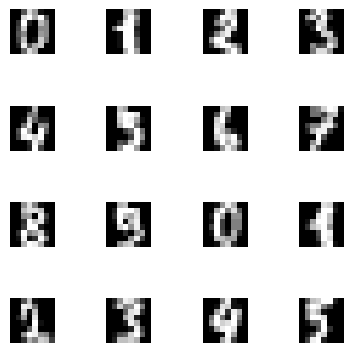

In [4]:
digits = load_digits()
x = digits.data[:16].astype(np.float32)

fig_data, axs = plt.subplots(4, 4, figsize=(4, 4))
fig_data.tight_layout()

for i in range(4):
    for j in range(4):
        img = np.reshape(x[4 * i + j], (8, 8))
        axs[i, j].imshow(img, cmap="gray")
        axs[i, j].axis("off")

In [5]:
#Loading the image data
train_data = Digits(mode="train")
val_data = Digits(mode="val")
test_data = Digits(mode="test")

# Initialize data loaders.
training_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [6]:
class Reshape(nn.Module):
    def __init__(self, size):
        super(Reshape, self).__init__()
        self.size = size  # a list

    def forward(self, x):
        assert x.shape[1] == np.prod(self.size)
        return x.view(x.shape[0], *self.size)

class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        return x.view(x.shape[0], -1)

In [279]:
#we represent a possible set of hyperparameter combinations in as arrays,
#for each possible element. All of these arrays are one-hot encoded
#and can be easily decoded with the corresponding array of hyperparameters

                            
hyperparameters = [[8,16,32], #number of filters
                   [[3,1,1], [5,2,1]],  #kernel=(3,3),padding=1 OR kernel=(5,5),padding=2 with both stride=1
                   [nn.ReLU(), nn.Sigmoid(), nn.Tanh(), nn.Softplus(), nn.ELU()], #activation functions
                   [nn.AvgPool2d(1),nn.Identity(),nn.MaxPool2d(1),nn.LPPool2d(1,1)], #pooling parameters
                   [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]] #number of neurons

#encoding
def generateOneHot(hyperparameters):
    hyperparametersOneHot = []
    for i in range(len(hyperparameters)):
        tmp = [0] * len(hyperparameters[i]) #create a list of zeros based on the current hyperparameter length
        tmp[rand.randrange(len(tmp))] = 1 #set a random list element to one
        hyperparametersOneHot.append(tmp)
    
    return hyperparametersOneHot

#decoding
def decodeHyperparam(i, encodedHyperparam):
    return np.argmax(encodedHyperparam[i])

#this is for demonstration
instance = generateOneHot(hyperparameters)
print(instance)
print(decodeHyperparam(0, instance))

[[1, 0, 0], [0, 1], [0, 1, 0, 0, 0], [0, 1, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]]
0


In [278]:
class ClassifierNeuralNet(nn.Module):
    def __init__(self, classnet):
        super(ClassifierNeuralNet, self).__init__()    
        self.classnet = classnet
        self.nll = nn.NLLLoss(reduction="none") 

    def classify(self, x):
        y_pred = torch.argmax(self.classnet(x), dim=1)
        return y_pred    
    
    def forward(self, x, y, reduction="avg"):
        loss = self.nll(self.classnet(x), y)
        
        if reduction == "sum":
            return loss.sum()
        else:
            return loss.mean()

In [277]:
def training(
    name, max_patience, num_epochs, model, optimizer, training_loader, val_loader
):
    nll_val = []
    error_val = []
    best_nll = 1000.0
    patience = 0

    # Main training loop
    for e in range(num_epochs):
        model.train()  # set the model to the training mode
        # load batches
        for indx_batch, (batch, targets) in enumerate(training_loader):
            # calculate the forward pass (loss function for given images and labels)
            loss = model.forward(batch, targets)
            # remember we need to zero gradients! Just in case!
            optimizer.zero_grad()
            # calculate backward pass
            loss.backward(retain_graph=True)
            # run the optimizer
            optimizer.step()

        # Validation: Evaluate the model on the validation data
        loss_e, error_e = evaluation(val_loader, model_best=model, epoch=e)
        nll_val.append(loss_e)  # save for plotting
        error_val.append(error_e)  # save for plotting

        # Early-stopping: update the best performing model and break training if no
        # progress is observed.
        if e == 0:
            torch.save(model, name + ".model")
            best_nll = loss_e            
        else:
            if loss_e < best_nll:
                torch.save(model, name + ".model")
                best_nll = loss_e
                patience = 0            
            else:
                patience = patience + 1                                            

        if patience > max_patience:
            break

    # Return nll and classification error.
    nll_val = np.asarray(nll_val)
    error_val = np.asarray(error_val)

    return nll_val, error_val

In [276]:
def evaluation(test_loader, name="CNN", model_best=None, epoch=None):
    # If available, load the best performing model
    if model_best is None:
        model_best = torch.load(name + ".model")

    model_best.eval()  # set the model to the evaluation mode
    loss_test = 0.0
    loss_error = 0.0
    N = 0.0
    # start evaluation
    for indx_batch, (test_batch, test_targets) in enumerate(test_loader):
        # loss (nll)
        loss_test_batch = model_best.forward(test_batch, test_targets, reduction="sum")
        loss_test = loss_test + loss_test_batch.item()
        # classification error
        y_pred = model_best.classify(test_batch)
        e = 1.0 * (y_pred == test_targets)
        loss_error = loss_error + (1.0 - e).sum().item()
        # the number of examples
        N = N + test_batch.shape[0]
    # divide by the number of examples
    loss_test = loss_test / N
    loss_error = loss_error / N

    # Print the performance
    '''if epoch is None:
        print(f"-> FINAL PERFORMANCE: nll={loss_test}, ce={loss_error}")
    else:
        if epoch % 10 == 0:
            print(f"Epoch: {epoch}, val nll={loss_test}, val ce={loss_error}")
    '''
    return loss_test, loss_error

In [275]:

# -> training hyperparams
lr = 1e-3  # learning rate
wd = 1e-5  # weight decay
train_epochs = 20  # max. number of epochs
max_patience = 5  # an early stopping is used, if training doesn't improve for longer than 20 epochs, it is stopped
name = "evoCNN"
result_dir = "./"
result_dir = os.path.join(result_dir, "results", name + "/")
if not (os.path.exists(result_dir)):
    os.makedirs(result_dir)
K = 10  # the number of labels    
#this is the height and width of our input image
input_attribute = 8
#out channels for the Conv2d layer
out_channels = 8

#the default value of dilation in nn.Conv2d
dilation = 1

#lambda for the penalty
lambd = 0.01

#calculation for the number of parameters for the largest possible model
#we define this as a constant since it does not need to be recalculated every single iteration
#first we need to calculate the output shape of the model before the linear layers,
#as it determines the number if input nodes for the linear layer
def calculateLinearInput(conv_layer, pooling_layer):
    ###########################################
    #calculate the output size after the pooling layer
    #we can "simulate" the first part of the network, before the linear layer, to determine the correct
    #output shape. While this can be calculated via mathematical forms, this method ensures an error free
    #and faster calculation
    
    # generate random input tensor for simulation
    input_tensor = torch.randn(64, 1, 8, 8)
    conv_output = conv_layer(input_tensor)
    # apply pooling
    pool_output = pooling_layer(conv_output)
    # apply flatten operation
    flatten = nn.Flatten()
    flattened_output = flatten(pool_output)
    linear_input_size = flattened_output.shape[1]
    
    return linear_input_size

#we define the largest conv2d layer
largest_conv_layer = nn.Conv2d(in_channels = 1, 
                               out_channels = out_channels, 
                               kernel_size=5,
                               dilation=dilation,
                               stride=stride,
                               padding=2)

#since Identity does not reduce the size 
#we still have to declare it as we use a method, which is generalized for other usecases
largest_pooling_layer = nn.Identity() 

largest_linear_input = calculateLinearInput(not_largest_conv_layer, largest_pooling_layer)

#to calculate the parameter count for the Conv2d layer, we can use to formula of
#param_number = output_channel_number * (input_channel_number * kernel_height * kernel_width)
conv2d_param_nr = out_channels*(1*5*5)

#and add the parameters of two layers, which for both is n*m, where n is the input node number
#and m is the output node number
#times 100, as thats the highest number of nodes defined
largest_nr_parameters = conv2d_param_nr + largest_linear_input*100+100*10

In [290]:
#function to calculate an istance's fitness  
def calculateFitness(oneHotParameters, num_epochs=train_epochs, loud=False):    
    #we first extract the hyperparameters from our onhot encodings
    num_kernels = hyperparameters[0][decodeHyperparam(0, oneHotParameters)]    
    kernel_size, padding, stride = hyperparameters[1][decodeHyperparam(1, oneHotParameters)]
    
    conv_layer = nn.Conv2d(in_channels = 1, 
                           out_channels = out_channels, 
                           kernel_size=kernel_size,
                           dilation=dilation,
                           stride=stride,
                           padding=padding)  # Convolutional layer
    
    activation_func = hyperparameters[2][decodeHyperparam(2, oneHotParameters)]    
    
    #pooling layer
    pooling = hyperparameters[3][decodeHyperparam(3, oneHotParameters)]
    
    #copying the pooling class, since we need to reinitialize with the proper parameters
    pool_class = type(pooling)
    
    #check if its 2x2 pooling and give the proper parameters
    #for some reason class type check (isinstance()) did not work here
    if decodeHyperparam(3, oneHotParameters) == 3:
        pooling_layer = pool_class(2, kernel_size)
    else:
        #since the Identity pool discards any arguments that it gets passed, we dont need to test for it
        pooling_layer = pool_class(kernel_size)
    
    #number of neurons
    nr_neurons = hyperparameters[4][decodeHyperparam(4, oneHotParameters)]
    
    #calculate the linear layer input size
    linear_input_size = calculateLinearInput(conv_layer, pooling_layer)
    
    classnet = nn.Sequential(
                Reshape((1, input_attribute, input_attribute)),  # reshape the input data
                conv_layer,
                pooling_layer,
                activation_func,
                nn.Flatten(),
                nn.Linear(linear_input_size, nr_neurons),          
                activation_func,
                nn.Linear(nr_neurons, 10),
                nn.Softmax(dim=1)  
            )
    
    model = ClassifierNeuralNet(classnet)
    
    #optimizer
    optimizer = torch.optim.Adamax(
        [p for p in model.parameters() if p.requires_grad == True],
        lr=lr,
        weight_decay=wd,
    )  

    #training procedure
    nll_val, error_val = training(
        name=result_dir + name,
        max_patience=max_patience,
        num_epochs=num_epochs,
        model=model,
        optimizer=optimizer,
        training_loader=training_loader,
        val_loader=val_loader,
    )

    #the final evaluation (on the test set)
    test_loss, test_error = evaluation(name=result_dir + name, test_loader=test_loader)
    
    #we can calculate the constructed model's parameters. including biases:
    current_model_params = sum(
        param.numel() for param in model.parameters()
    )
    
    #we substract the biases, since we only care about the weight numbers:
    #for the conv2d layer its the number of output channels,    
    #while for the Linear layers its the number of input nodes
    current_model_params -= (out_channels + linear_input_size + nr_neurons)
    
    #we add a penalty based on our feature numbers calculated earlier 
    penalty = lambd*(current_model_params/largest_nr_parameters)  
    
    if(loud):
        return nll_val, error_val
    else:
        return test_error + penalty

In [283]:
class EA(object):
    def __init__(self,pop_size, mutation_threshold=0.25, crossover = "one"):    
        self.pop_size = pop_size
        
        #we set a threshold for randomly mutating the genes, the default value is 25%
        self.mutation_threshold = mutation_threshold
        
        #we can set which crossover function do we want to use
        #the default value is "one", which stands for 
        self.crossover = crossover
    
    #this is a helper function
    #this sorts by the fitness values in an ascending order and can also handle inf values  
    def sorter(self, fitness, genes):
        args = fitness.argsort()
        
        fitness = fitness[args]
        genes = genes[args]
        
        return fitness, genes
    
    def parent_selection(self, x_old, f_old):
        # implementing rank selection, since then we dont need to care about inf values
        x_parents = x_old #population array 
        f_parents = f_old #fitness values (float)
    
        #sorting the two list paralell, so they keep their relative position              
        f_parents, x_parents = self.sorter(f_parents, x_parents)
        
        # choose the best 50 parents by rank and pass them forward to recombination
        # since its a sorted ascending list we can just take the first 50 elements
        f_parents, x_parents = f_parents[0:50], x_parents[0:50]
        return x_parents, f_parents

    def recombination(self, x_parents, f_parents):
        x_children = []
        #with every crossover function we iterate through all parents-1,
        #since we want to mate every parent with the following parent in the list
        #this way we wont be out of bounds for the parent list
        
        #we craft the fused genes in the x_sub variable which we store and return with the x_children list
        #one point crossover
        if self.crossover == "one":
            for i in range(len(x_parents)-1):
                # see the else statement for explanation for the random number generation
                cross_point = np.random.randint(1,len(x_parents[i]))                
                #by the chosen point we add up the two genes
                x_sub = x_parents[i][0:cross_point]
                x_sub2 = x_parents[i+1][cross_point:]
                x_sub = np.append(x_sub, x_sub2)                       
                x_children.append(x_sub)        
                
        #lets keep the numpy array property, as up until to this point we worked with normal arrays
        return np.asarray(x_children)

    def mutation(self, x_children):
        # Random Resetting mutation:
        for i in range(len(x_children)):
            for t in range(len(x_children[i])):
                #we draw a random sample from a uniform distribution between 0 and 1
                #if its below the threshold we mutate a gene randomly according to the corresponding boundaries
                if np.random.uniform(0,1)<self.mutation_threshold:                                        
                    tmp = [0] * len(x_children[i][t]) #create a list of zeros based on the current hyperparameter length
                    tmp[rand.randrange(len(tmp))] = 1 #set a random list element to one
                    x_children[i][t] = tmp
                    
        return x_children

    def survivor_selection(self, x_old, x_children, f_old, f_children):
        x = np.concatenate([x_old, x_children])
        f = np.concatenate([f_old, f_children])

        # Fitness Based Selection
        # its easy to implement since we can reuse previously implemented code
        # just sort the candidates again based on fitness and 
        # choose the top candidates to fill in the required population        
        f, x = self.sorter(f, x)
        x, f = x[0:pop_size], f[0:pop_size]
        
        return x, f

    # Evaluation step:
    def evaluate(self, x):
        fitness_values = []
        for instance in x:
            fitness_values.append(calculateFitness(instance))
            
        return np.asarray(fitness_values)

    def step(self, x_old, f_old):
        x_parents, f_parents = self.parent_selection(x_old, f_old)
        
        x_children = self.recombination(x_parents, f_parents)

        x_children = self.mutation(x_children)

        f_children = self.evaluate(x_children)

        x, f = self.survivor_selection(x_old, x_children, f_old, f_children)
        return x, f

In [284]:
num_generations = 50
pop_size = 20

ea = EA(calculateFitness,pop_size)

# Init the population
x = [generateOneHot(hyperparameters) for _ in range(pop_size)]
x = np.asarray(x)

f = ea.evaluate(x)
# We want to gather populations and values of the best candidates to further
# analyze the algorithm.
populations = []
populations.append(x)
f_best = [min(f)]
best_model = [x[np.argmin(f)]]

# Run the EA.
for i in range(num_generations):
    if i % int(num_generations * 0.1) == 0 or i<=5:
        print("Generation: {}, best fitness: {:.2f}".format(i, min(f)))
    x, f = ea.step(x, f)
    populations.append(x)
    if f.min() < f_best[-1]:
        #we save the best fitness and the best model for later reuse and testing
        f_best.append(min(f))
        best_model = [x[np.argmin(f)]]
    else:
        f_best.append(f_best[-1])
        best_model = [best_model[-1]]
print("FINISHED!")
print("best model: ", best_model[-1])

/tmp/ipykernel_72059/2122061573.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asarray(x)


Generation: 0, best fitness: 0.18
Generation: 1, best fitness: 0.09
Generation: 2, best fitness: 0.09
Generation: 3, best fitness: 0.09
Generation: 4, best fitness: 0.08
Generation: 5, best fitness: 0.08
Generation: 10, best fitness: 0.08
Generation: 15, best fitness: 0.08
Generation: 20, best fitness: 0.08
Generation: 25, best fitness: 0.08
Generation: 30, best fitness: 0.08
Generation: 35, best fitness: 0.07
Generation: 40, best fitness: 0.07
Generation: 45, best fitness: 0.07
FINISHED!
best model:  [list([0, 0, 1]) list([1, 0]) list([0, 0, 1, 0, 0]) list([0, 1, 0, 0])
 list([0, 0, 1, 0, 0, 0, 0, 0, 0, 0])]


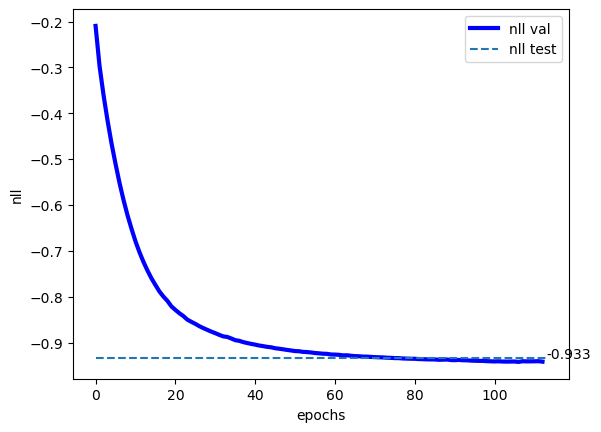

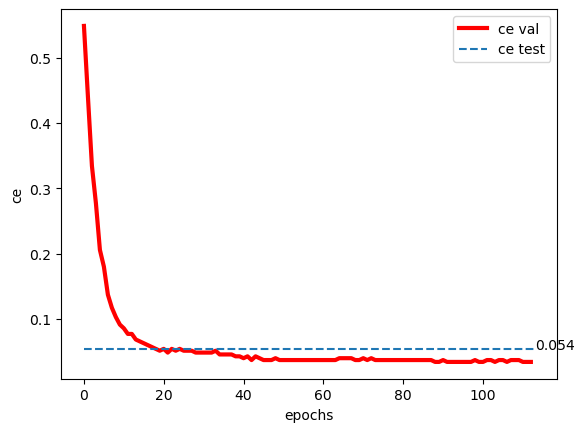

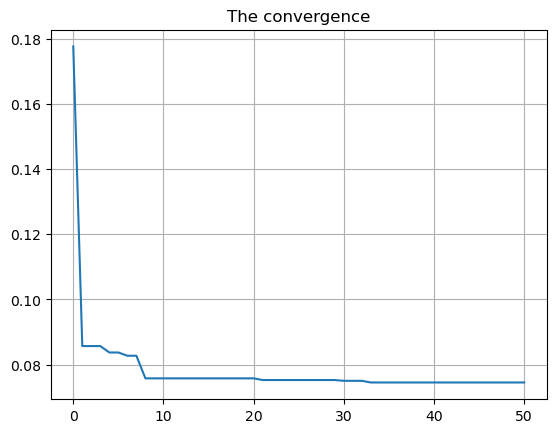

In [291]:
#visualizing the best model
import matplotlib.pyplot as plt

#evaluating the best model with proper training epoch size:
eval_epoch = 1000
val_loss, val_error = calculateFitness(best_model[-1], num_epochs=eval_epoch, loud=True)

def plot_curve(
    name,
    signal,
    file_name="curve.pdf",
    xlabel="epochs",
    ylabel="nll",
    color="b-",
    test_eval=None,
):
    # plot the curve
    plt.plot(
        np.arange(len(signal)), signal, color, linewidth="3", label=ylabel + " val"
    )
    # if available, add the final (test) performance
    if test_eval is not None:
        plt.hlines(
            test_eval,
            xmin=0,
            xmax=len(signal),
            linestyles="dashed",
            label=ylabel + " test",
        )
        plt.text(
            len(signal),
            test_eval,
            "{:.3f}".format(test_eval),
        )
    # set x- and ylabels, add legend, save the figure
    plt.xlabel(xlabel), plt.ylabel(ylabel)
    plt.legend()
    plt.savefig(name + file_name, bbox_inches="tight")
    plt.show()

plot_curve(
    result_dir + name,
    val_loss,
    file_name="_nll_val_curve.pdf",
    ylabel="nll",
    test_eval=test_loss,
)
plot_curve(
    result_dir + name,
    val_error,
    file_name="_ca_val_curve.pdf",
    ylabel="ce",
    color="r-",
    test_eval=test_error,
)

plt.plot(range(len(f_best)), f_best)
plt.title("The convergence")
plt.grid()